# Exploratory data analysis

<a name="content"> </a>
## Table of contents
---

* [Dataset summary](#step1)

Dataset summary with basic statistics and respective plots;

* [Feature importances](#step2)

* [Recursive feature elimination](#step3)

* [Confidence intervals](#step4)


* [Hypotheses testing](#step5)

Testing statistical hypotheses

* [Gaussian mixture model](#step6)

* [Clusterization in PCA space](#step7)

* [Inferences](#step8)

In [1]:
import pandas as pd
import pingouin as pg
import scipy.stats as sts
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import probplot, kstest, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats import weightstats
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import os
from nltk.stem import WordNetLemmatizer
from collections import Counter
from datetime import datetime
import matplotlib.gridspec as gridspec
import warnings
from tqdm import tqdm
from mycolorpy import colorlist as mcp
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = "../scrapped_data"
SCRAPPED_DATA_PATH = os.path.join(DATA_PATH, "scrapped_data_topics.csv")
MOST_COMMON_COUNT = 100

## Preparation stage

In [3]:
df = pd.read_csv(SCRAPPED_DATA_PATH)
print(df.shape)
df.sample(3)

(9933, 30)


,title,publication,link,author,followers,reading_time,n_words,pure_text,date,responses,...,year,month,dow,language,season,key_word_1,key_word_2,key_word_3,topic,topic_name
3284,What my kids taught me about writing code…and ...,The Startup,https://medium.com/swlh/what-my-kids-taught-me...,Jared Stromberg,21,4,823,"Two months ago, my 18 month old decided it was...",28/06/2019,0,...,2022,June,Friday,en,summer,feel,something,sleep,0,life
8833,How to remove OSD from Ceph cluster,Towards Data Science,https://medium.com/@george.shuklin/how-to-remo...,George Shuklin,1100,1,58,It is not well described in the docs.Look into...,20/05/2016,3,...,2021,May,Friday,en,spring,image,could,product,-1,business
9737,Dirichlet distribution,Towards Data Science,https://towardsdatascience.com/dirichlet-distr...,Sue Liu,110,7,1366,"A few months ago, I built a recommender system...",06/01/2019,6,...,2019,January,Sunday,en,winter,distribution,unsupervised,clustering,55,topic


In [4]:
df["ago"] = abs(df["date"].apply(lambda date: pd.Timestamp(date).date()) - datetime.today().date())
df["ago"] = pd.to_numeric(df['ago'].dt.days, downcast='integer')

In [5]:
df.columns

Index(['title', 'publication', 'link', 'author', 'followers', 'reading_time',
       'n_words', 'pure_text', 'date', 'responses', 'n_code_chunks',
       'bold_text_count', 'italic_text_count', 'mean_image_width',
       'mean_image_height', 'n_images', 'n_lists', 'n_vids', 'n_links',
       'claps', 'year', 'month', 'dow', 'language', 'season', 'key_word_1',
       'key_word_2', 'key_word_3', 'topic', 'topic_name', 'ago'],
      dtype='object')

In [7]:
num_cols = ["followers", "reading_time", "n_words", 
            "responses", "n_code_chunks", "bold_text_count", 
            "italic_text_count", "mean_image_width",
            "mean_image_height", "n_images", "n_lists", 
            "n_vids", "n_links", "claps", "ago"
]
keyword_columns = [f"key_word_{i}" for i in range(1, 11)]

cat_cols = [
    "publication", "author", 
    "month", "dow", "language",
    "season", "year"
]

cat_cols += keyword_columns

## Dataset summary

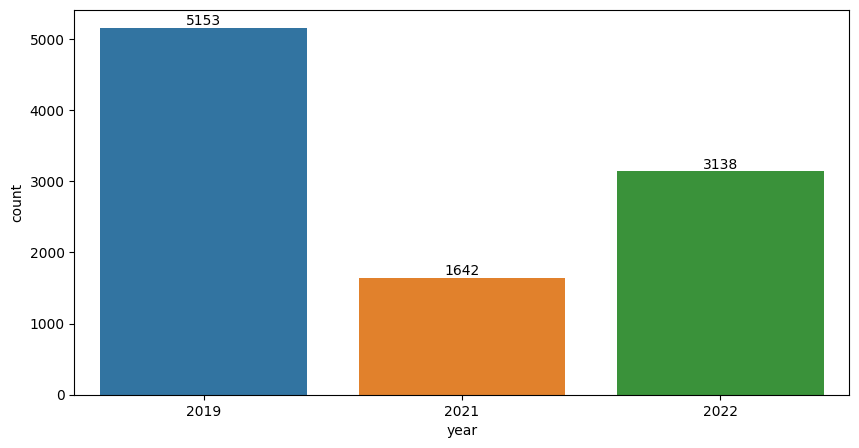

In [218]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="year", data=df)
ax.bar_label(ax.containers[0]);


Больше всего данных за 2019 год.

In [17]:
import plotly.express as px

mask = (df.n_words > 0) & (df.claps > 0)
followers = df.followers[mask].copy()
followers[followers > 2000] = 2000

px.scatter(x=np.log(df.n_words[mask]), y=np.log(df.claps[mask]), color=followers, opacity=0.7)

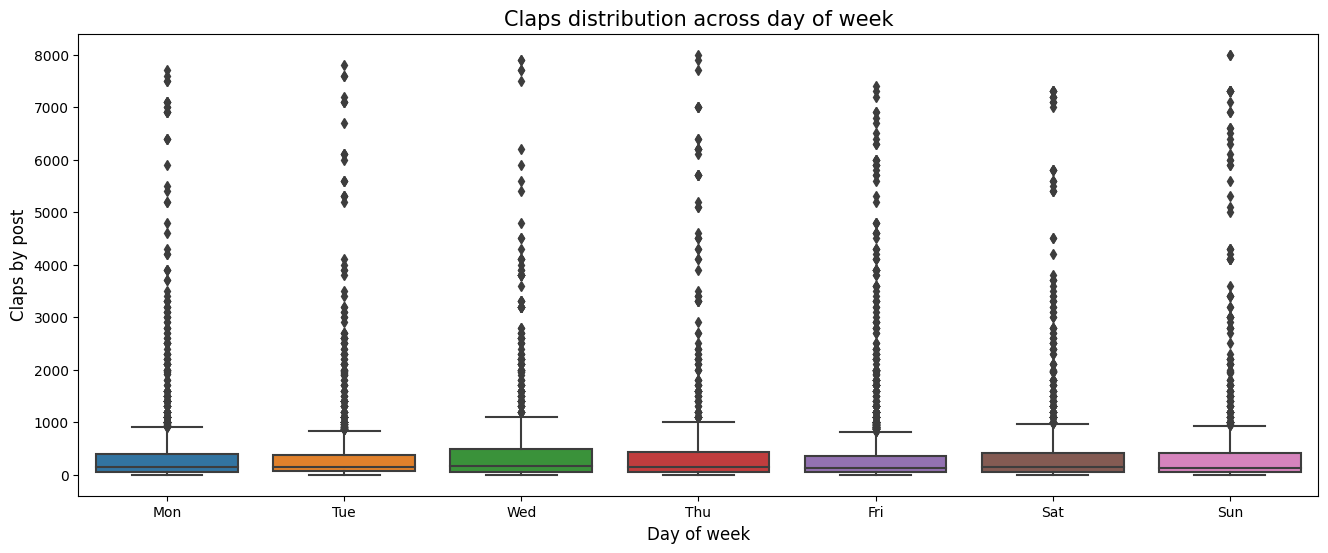

In [242]:
plt.figure(figsize=(16,6))

ax1 = sns.boxplot(y='claps',x='dow', data=df)
plt.ylabel('Claps by post', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Claps distribution across day of week', fontsize=15)
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

<AxesSubplot: xlabel='dow', ylabel='count'>

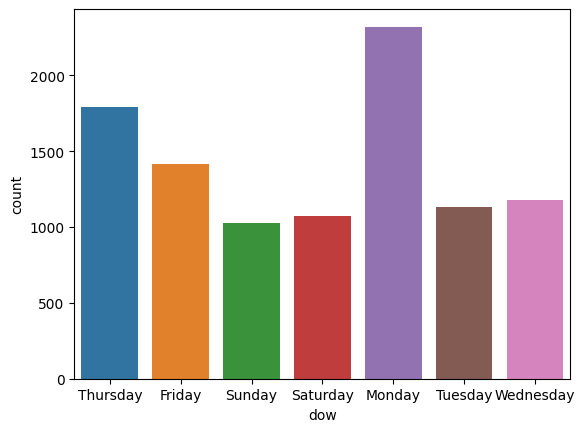

In [9]:
sns.countplot(x="dow", data=df)

<AxesSubplot: xlabel='dow', ylabel='claps'>

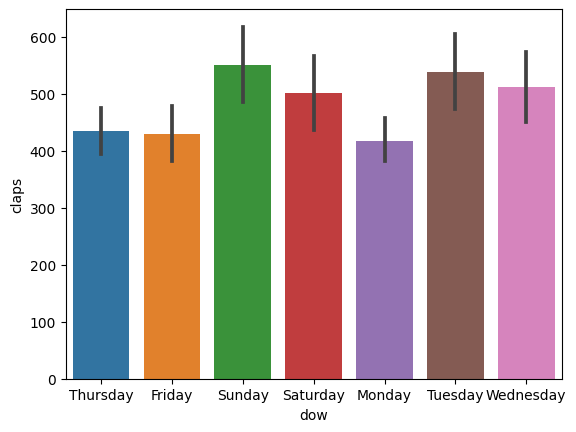

In [246]:
sns.barplot(x=df["dow"], y=df["claps"])

In [19]:
top_5_popular_publications = df["publication"].value_counts()[:5].index
claps = df.loc[df.publication.isin(top_5_popular_publications)].groupby('publication')['claps'].sum().sort_values(ascending=False).reset_index()
px.bar(claps, x="publication", y="claps")

In [20]:
responses = df.loc[df.publication.isin(top_5_popular_publications)].groupby('publication')['responses'].sum().sort_values(ascending=False).reset_index()
px.bar(responses, x="publication", y="responses")

In [22]:
reading_time = df.loc[df.publication.isin(top_5_popular_publications)].groupby('publication')['reading_time'].sum().sort_values(ascending=False).reset_index()
px.bar(reading_time, x="publication", y="reading_time")

In [23]:
date_gr = df.loc[df.publication.isin(top_5_popular_publications)].groupby('month')['publication'].count().sort_values(ascending=False).reset_index()

plt.figure(figsize = (10,8))
px.bar(date_gr, x= 'month', y='publication', color = 'publication',hover_data=['publication'],
       title="Month wise Publication" )

<Figure size 1000x800 with 0 Axes>

<AxesSubplot: xlabel='publication', ylabel='count'>

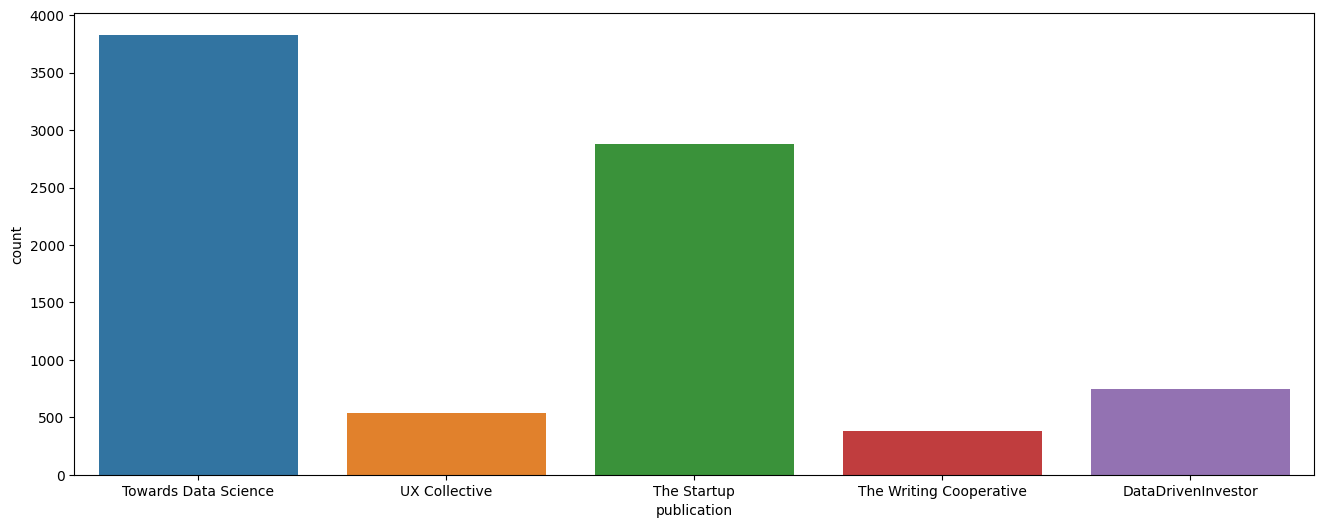

In [27]:
plt.figure(figsize=(16,6))

sns.countplot(x='publication',data=df.loc[df["publication"].isin(top_5_popular_publications)])

In [28]:
publ = df.loc[df["publication"].isin(top_5_popular_publications)].groupby('publication')['reading_time'].sum().sort_values(ascending=False)
fig = px.pie(publ,values = publ.values, names=publ.index,
            title='Publication with Highest Reading Time')
fig.show()

In [29]:
topic_resp = df.groupby('topic_name')['responses'].max().sort_values(ascending= False).head(10).reset_index()
px.bar(topic_resp, x= 'topic_name', y='responses',title="Articles with Highest responses" )

In [31]:
topic_resp = df.groupby('key_word_1')['responses'].max().sort_values(ascending= False).head(10).reset_index()
px.bar(topic_resp, x= 'key_word_1', y='responses',title="Articles with Highest responses" )

In [32]:
topic_resp = df.groupby('key_word_2')['responses'].max().sort_values(ascending= False).head(10).reset_index()
px.bar(topic_resp, x= 'key_word_2', y='responses',title="Articles with Highest responses" )

In [33]:
topic_resp = df.groupby('key_word_3')['responses'].max().sort_values(ascending= False).head(10).reset_index()
px.bar(topic_resp, x= 'key_word_3', y='responses',title="Articles with Highest responses" )

In [30]:
topic_resp = df.groupby('topic_name')['claps'].max().sort_values(ascending= False).head(10).reset_index()
px.bar(topic_resp, x= 'topic_name', y='claps',title="Articles with Highest claps" )

In [45]:
num_cols_to_plot = [
    "followers", "reading_time", "n_words", 
    "responses", "n_images", "n_links", "claps", "ago"
]
least_cols = set(num_cols) - set(num_cols_to_plot)

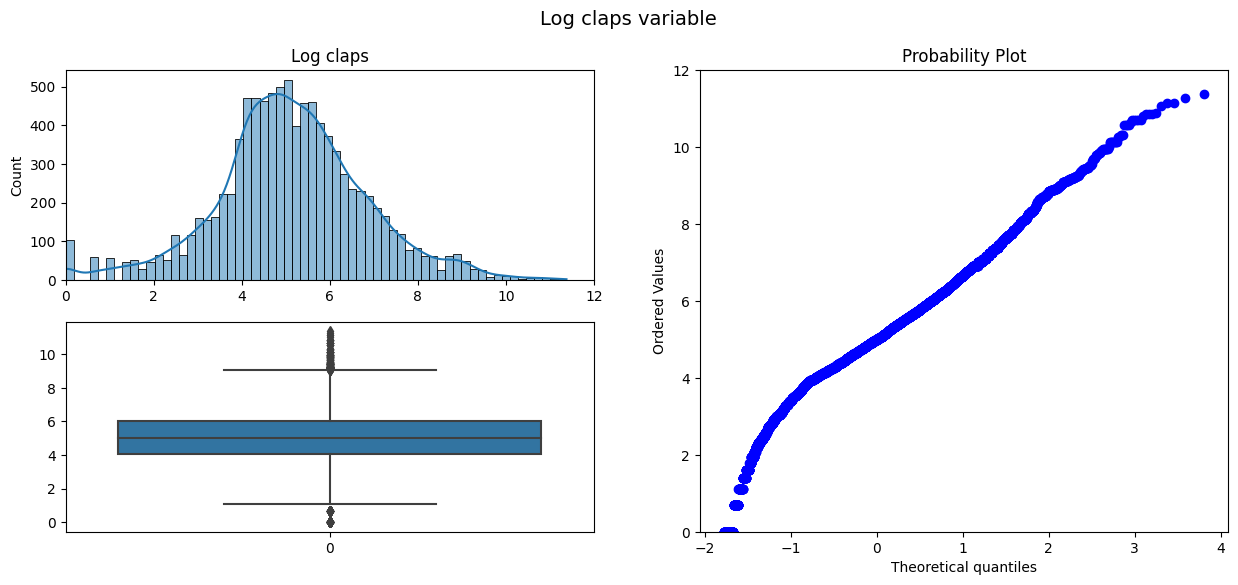

In [124]:
plt.figure(figsize=(15,6))
plt.suptitle("Log claps variable", fontsize=14)
gridspec.GridSpec(2,2)

plt.subplot2grid((2,2),(0,0))
plt.xlim(0, 12)
sns.histplot(np.log(df.claps.values), kde=True, color=sns.color_palette()[0])
plt.title("Log claps")

plt.subplot2grid((2,2),(1,0))
plt.xlim(0, 12)
sns.boxplot(np.log(df.claps.values))

plt.subplot2grid((2,2),(0,1), rowspan=2)
plt.ylim(0, 12)
probplot(np.log(df.claps.values), dist="norm", plot=plt);

The empirical non-parametric distribution of logarithm of claps not so far from normal distribution. That is why we can use the parametric stats for this value. But we need to keep in mind that there are a lot of zeros and outliers.

In [108]:
df.claps.max()

87000

Lets watch on the categorical features

In [156]:
cols_pie_names = [
    "Publication type",
    "Year", "Month",
    "Day of week", 
    "Language", "Season"
] + keyword_columns
pie_cols = [
    'publication',
    'year', 'month',
    'dow', 'language',
    'season'
] + keyword_columns

100%|██████████| 16/16 [00:00<00:00, 30.78it/s]


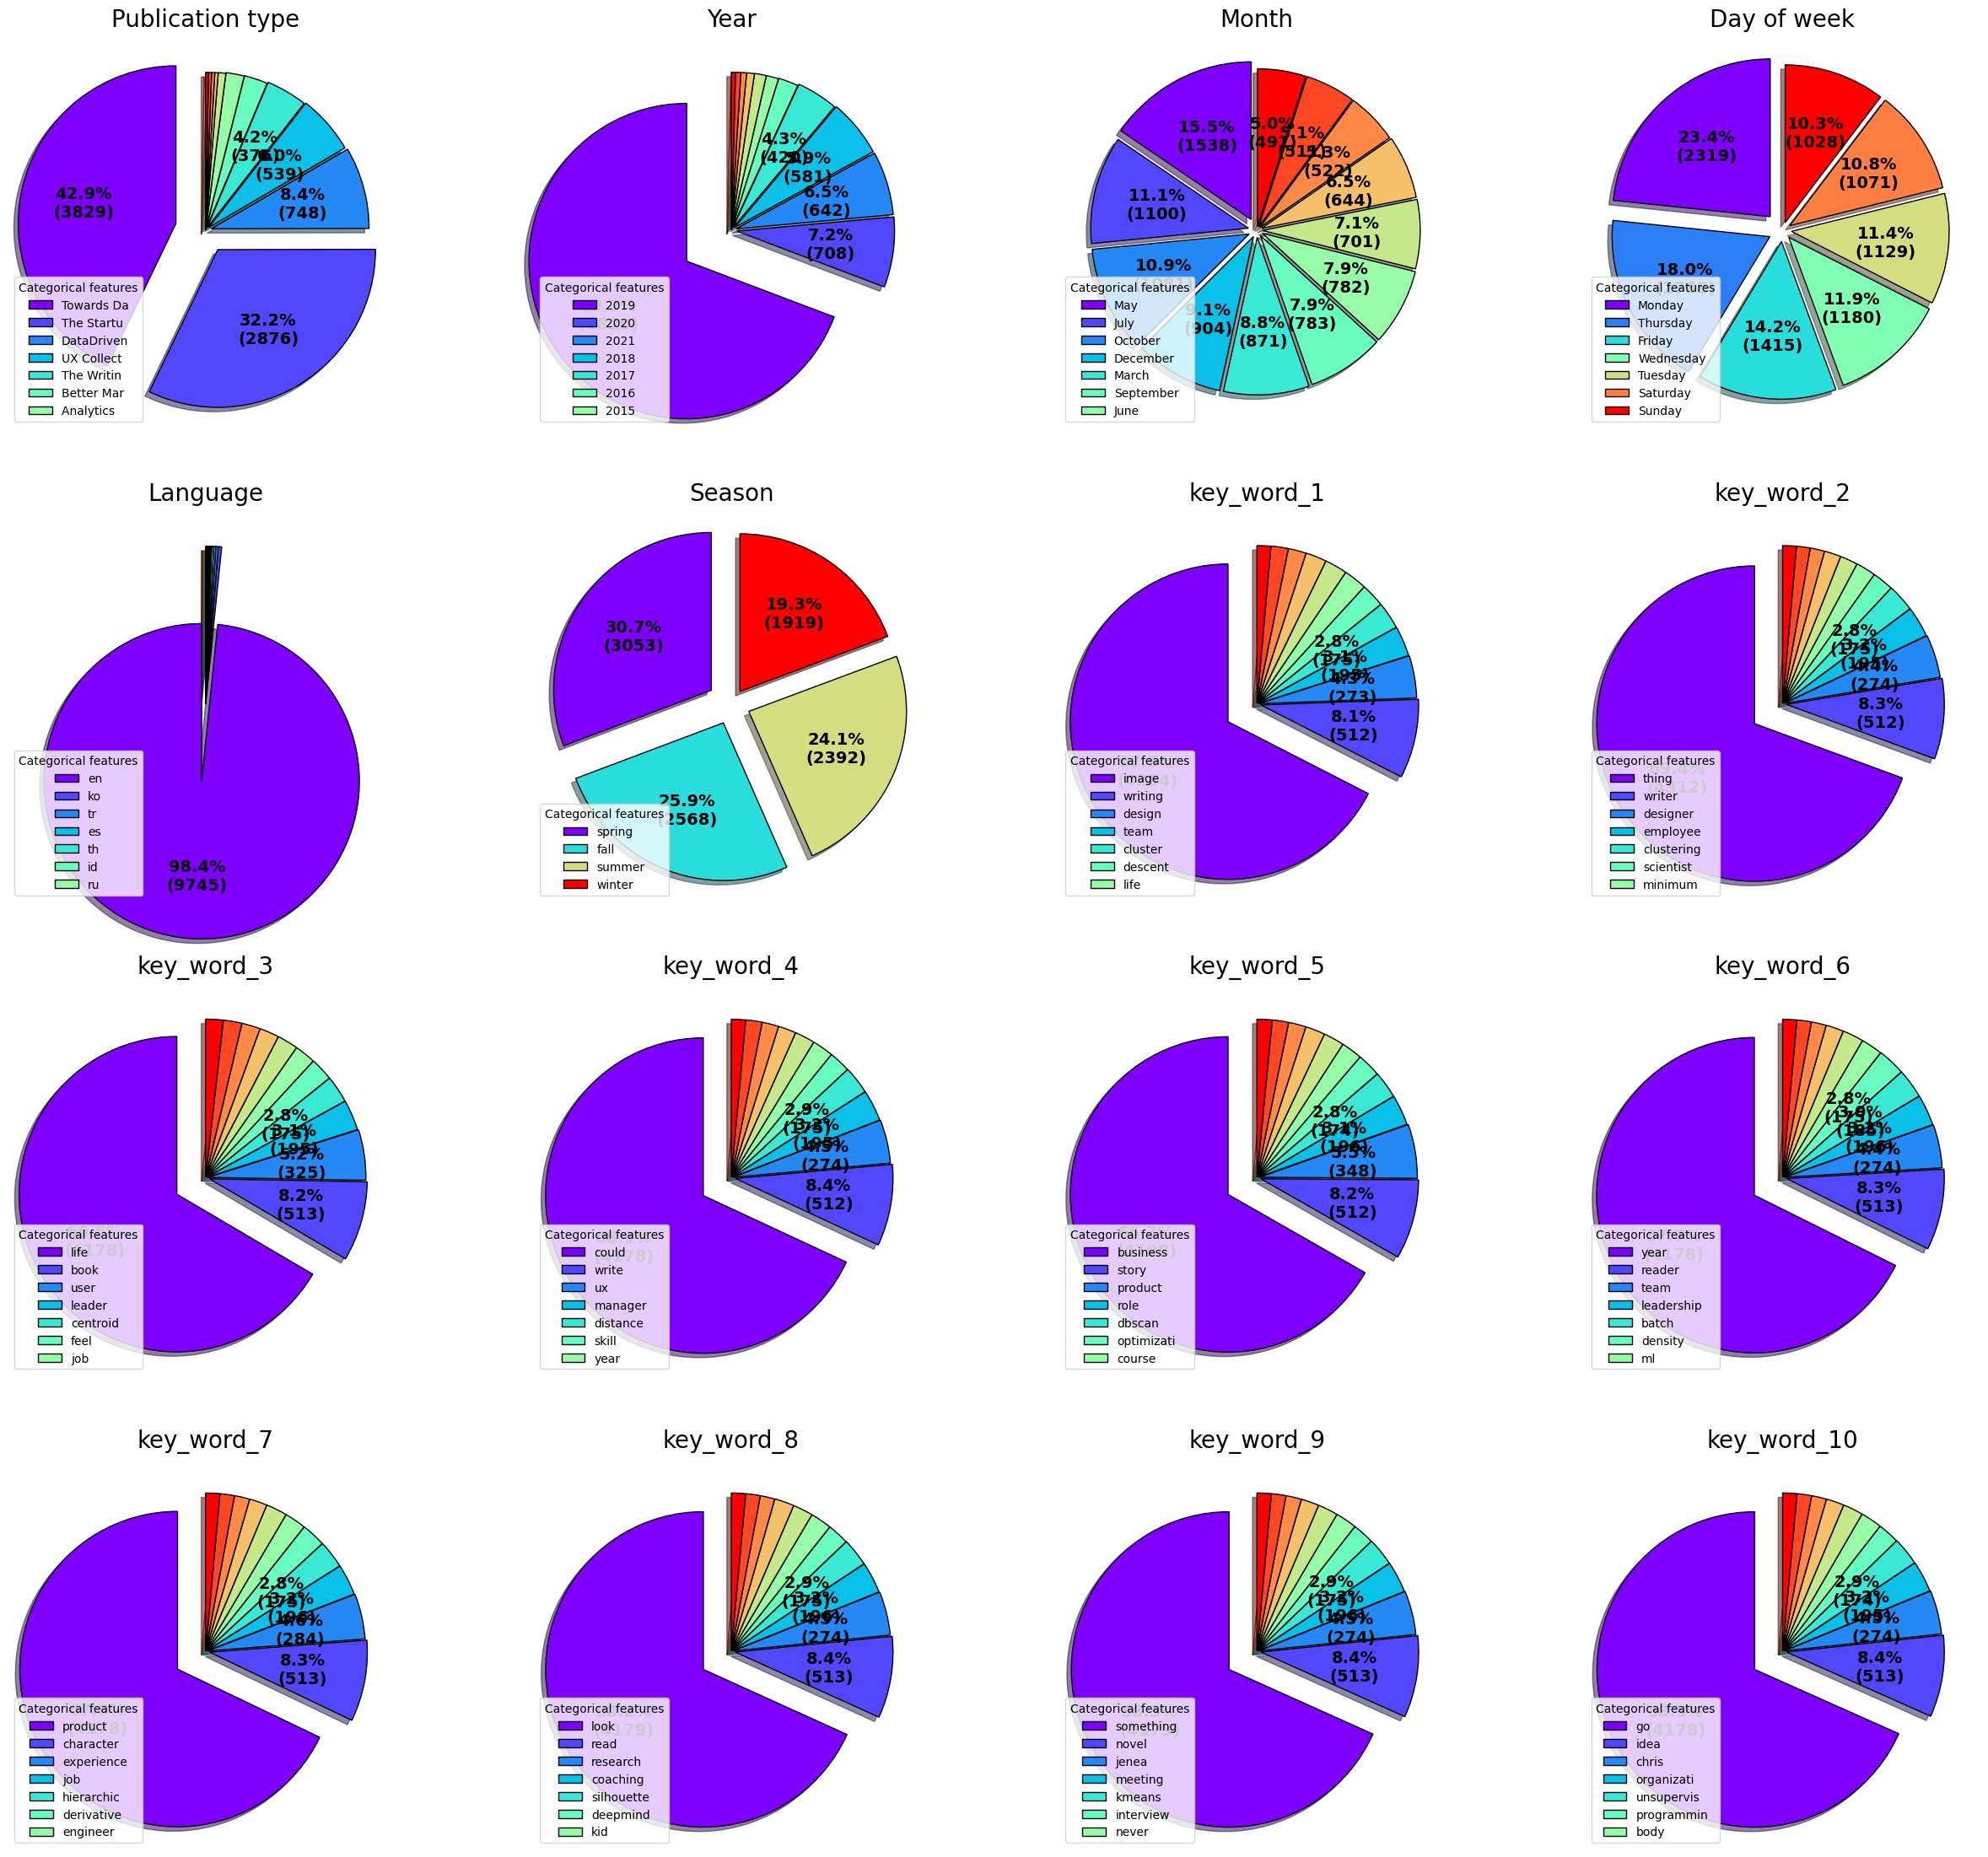

In [158]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    if pct > 2.5:
        return "{:.1f}%\n({:d})".format(pct, absolute)
    else:
        return ''
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
# Creating plot
fig, ax = plt.subplots(4, 4, figsize =(25, 25))
for i, (col, title) in tqdm(enumerate(zip(pie_cols, cols_pie_names)), total=len(pie_cols)):
    vc = df[col].value_counts()
    data = vc.values.astype(int)[:12]
    labels = [st[:10] for st in df[col].value_counts().keys().astype(str)][:12]
    sum_ = df[col].value_counts().values.sum()
    explode = [i / sum_ / 2 for i in data]
    wp = { 'linewidth' : 1, 'edgecolor' : "black" }

    wedges, texts, autotexts = ax[i // 4][i % 4].pie(data, 
            autopct = lambda pct: func(pct, data), 
            explode=explode,
            wedgeprops=wp,
            colors=mcp.gen_color(cmap="rainbow",n=len(labels)),
            shadow=True,
            startangle=90)
    ax[i // 4][i % 4].legend(wedges, labels[:7],
          title ="Categorical features",
          loc ="lower left",
          bbox_to_anchor =(0, 0, 0.5, 1))
    ax[i // 4][i % 4].set_aspect('equal')
    ax[i // 4][i % 4].set_title(title, fontdict={'fontsize': 20})
    plt.setp(autotexts, size = 14, weight ="bold", color="black")
    plt.subplots_adjust(wspace=-10, hspace=None)
plt.tight_layout()

In [159]:
from nltk.tokenize import word_tokenize

num_words = df.pure_text.apply(word_tokenize).apply(len)

## Feature importances